In [1]:
import os
from matplotlib import pyplot as plt

# prepare data
pics = os.listdir("./pics")
data_imgs = []
data_labels = []

for pic in pics:
    img = plt.imread(f"./pics/{pic}")
    data_imgs.append(img)
    if len(img.shape) == 3:
        data_labels.append(0)
    else:
        data_labels.append(1)


In [2]:
# transform data to 256x256
import albumentations as A
import torch
import random

transform = A.Compose(
    [
        A.RandomCrop(width=64, height=64, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Resize(p=1.0, height=128, width=128),
        A.ToGray(p=1.0),
    ]
    
)
data_imgs_transformed = []
for data_img in data_imgs:
    transformed = transform(image=data_img)['image'][:,:,0] if len(data_img.shape)==3 else transform(image=data_img)['image']
    data_imgs_transformed.append(torch.tensor(transformed).float().unsqueeze(2).permute(2,0,1))
index_shuffle = list(range(len(data_imgs_transformed)))
random.shuffle(index_shuffle)
train_data = torch.stack(data_imgs_transformed)[index_shuffle[:int(len(data_imgs_transformed)*0.8)]]
train_labels = torch.tensor(data_labels)[index_shuffle[:int(len(data_imgs_transformed)*0.8)]]
test_data = torch.stack(data_imgs_transformed)[index_shuffle[int(len(data_imgs_transformed)*0.8):]]
test_labels = torch.tensor(data_labels)[index_shuffle[int(len(data_imgs_transformed)*0.8):]]

C:\Users\JHW\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\transforms.py:1724: UserWarning: The image is already gray.
  warnings.warn("The image is already gray.")


In [3]:
# define bp network
import torch.nn as nn
import torch

class bp(nn.Module):
    def __init__(self, hidden_dims=[1, 64, 128, 64, 1]):
        super(bp, self).__init__()
        module_lst = []
        for i in range(len(hidden_dims)-1): # 128x128 -> 64x64 -> 32x32 -> 16x18 -> 8x8
            module_lst.append(nn.Conv2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1))
        module_lst.append(nn.Flatten())
        module_lst.append(nn.Linear(hidden_dims[-1]*8*8, hidden_dims[-1]*8*8))
        module_lst.append(nn.ReLU())
        module_lst.append(nn.Linear(hidden_dims[-1]*8*8, 2))
        self.model = nn.Sequential(*module_lst)
        self.init_params()
        
    def forward(self, x):
        return self.model(x)
    
    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)


In [4]:
model = bp()

In [5]:
# loss function and optimizer
import tqdm

seed=42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

bp_model = bp()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bp_model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_epoch = []
eval_epoch = []
loss_lst = []
val_loss_lst = []
acc_epoch = []
acc_lst = []
# train and test
for epoch in tqdm.tqdm(range(60)):
    bp_model.train()
    optimizer.zero_grad()
    outputs = bp_model(train_data)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    loss_lst.append(loss.item())
    train_epoch.append(epoch+1)
    lr_scheduler.step()
    # print(f"lr: {lr_scheduler.get_last_lr()[0]}")
    if (epoch) % 1 == 0:
        eval_epoch.append(epoch+1)
        # print(f"epoch {epoch}, loss {loss.item()}")
        bp_model.eval()
        with torch.no_grad():
            val_outputs = bp_model(test_data)
            val_loss = criterion(val_outputs, test_labels)
            val_loss_lst.append(val_loss.item())
            # print(f"epoch {epoch}, val_loss {val_loss.item()}")
            predicts = torch.argmax(val_outputs, dim=1)
            correct = (predicts == test_labels).sum().item()
            acc = correct / len(test_labels)
            # print(f"epoch {epoch}, acc {acc}")
            acc_epoch.append(epoch+1)
            acc_lst.append(acc)

    

100%|██████████| 60/60 [00:05<00:00, 10.61it/s]


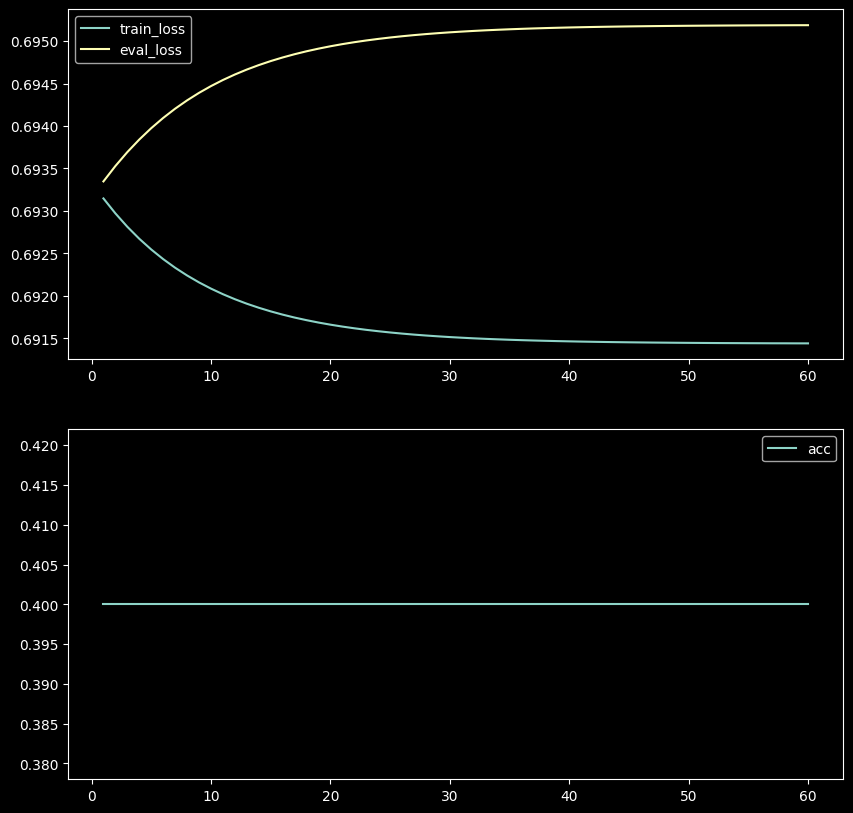

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0].plot(train_epoch, loss_lst, label="train_loss")
axes[0].plot(eval_epoch, val_loss_lst, label="eval_loss")
axes[0].legend()
axes[1].plot(acc_epoch, acc_lst, label="acc")
axes[1].legend()
plt.show()